In [17]:
from ib_insync import *
from matplotlib import pyplot as plt
import math
util.startLoop()

ib = IB()
#ib.connect('127.0.0.1', 4001, clientId=1)

In [23]:
ib.connect('127.0.0.1', 8331, clientId=4)
from account_management import query_account_info_return_str
output_str, _ = query_account_info_return_str(ib=ib)
print(output_str)

Avaliable accounts=['U10401338', 'U11654341']
-----Listing Account ID = U10401338-----
Cash Balance = $124.15
Buying Power = $111700.6
Unrealized PnL = $939.24
Position(s) in this account:
TLT * 400.0 @ 90.321903

-----Listing Account ID = U11654341-----
Cash Balance = $190.39
Buying Power = $6538.0
Unrealized PnL = $-0.38
Position(s) in this account:
BIL * 21.0 @ 91.70761905




In [33]:
spx = Contract(symbol='SPX',secType='IND')
ndx = Contract(symbol='NDX',secType='IND')
ib.qualifyContracts(spx)
ib.reqHeadTimeStamp(spx,whatToShow='TRADES', useRTH=True)
ib.qualifyContracts(ndx)
ib.reqHeadTimeStamp(ndx,whatToShow='TRADES', useRTH=True)
print(spx)
print(ndx)
spx_bars=ib.reqHistoricalData(
    contract=spx,
    endDateTime='',
    durationStr='60 S',
    barSizeSetting='1 secs',
    whatToShow='TRADES',
    useRTH=False,
    formatDate='1'
)
ndx_bars=ib.reqHistoricalData(
    contract=ndx,
    endDateTime='',
    durationStr='60 S',
    barSizeSetting='1 secs',
    whatToShow='TRADES',
    useRTH=False,
    formatDate='1'
)
print(spx_bars[0])

Contract(secType='IND', conId=416904, symbol='SPX', exchange='CBOE', currency='USD', localSymbol='SPX')
Contract(secType='IND', conId=416843, symbol='NDX', exchange='NASDAQ', currency='USD', localSymbol='NDX')
BarData(date=datetime.datetime(2024, 7, 22, 12, 59), open=5563.39, high=5563.39, low=5563.39, close=5563.39, volume=0.0, average=0.0, barCount=1)


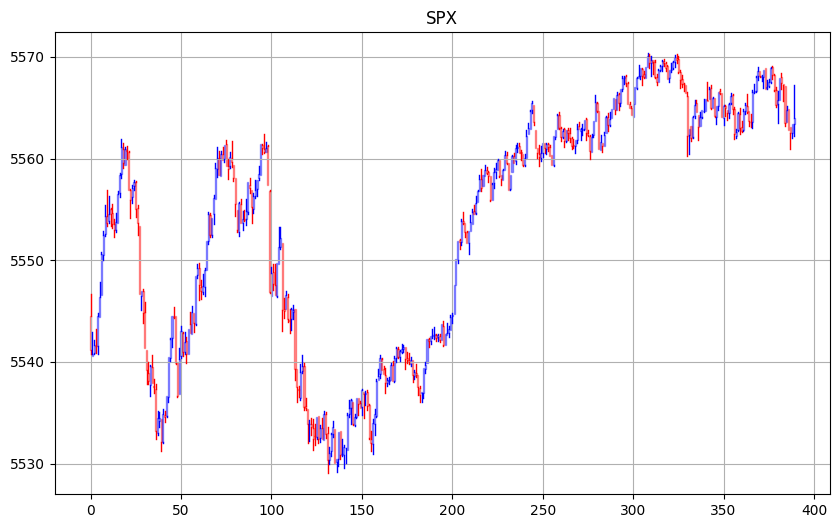

In [59]:
spx=Contract(symbol='SPX',secType='IND')
ib.qualifyContracts(spx)
ib.reqHeadTimeStamp(spx,whatToShow='TRADES', useRTH=True)
bars=ib.reqHistoricalData(
    contract=spx,
    endDateTime='',
    durationStr='1 D',
    barSizeSetting='1 min',
    whatToShow='TRADES',
    useRTH=True,
    formatDate='1'
)
df=util.df(bars)
#plt.plot(df['close'])
util.barplot(bars, title=spx.symbol)
spxVal = bars[-1].close

Filter out qulified option legs from certain strike price range：

In [61]:
chains=ib.reqSecDefOptParams(spx.symbol,'',spx.secType, spx.conId)
chain=next(c for c in chains if c.tradingClass=='SPXW' and c.exchange=='SMART')
strikes=[stk for stk in chain.strikes if stk%5==0 and spxVal-5<stk<spxVal+5]
expiration=sorted(exp for exp in chain.expirations)[:1]
rights=['P']
contracts=[Option('SPX',exp,stk,right,'SMART')
           for right in rights
           for exp in expiration
           for stk in strikes]
contracts=ib.qualifyContracts(*contracts)
#print(tickers)

#tickers=ib.reqTickers(*contracts)



In [63]:
tickers=ib.reqTickers(*contracts)
for ticker in tickers:
    print(ticker.lastGreeks.impliedVol*math.sqrt(1/252)*spxVal)

55.51570873752034
54.538352284955536


In [55]:
[ticker]=ib.reqTickers(spx)
spxVal=ticker.marketPrice()
if math.isnan(spxVal):
    spxVal=bars[-1].close
print('spx='+str(spxVal))
chains=ib.reqSecDefOptParams(spx.symbol,'',spx.secType, spx.conId)
#print('Chains='+str(chains))
chain=next(c for c in chains if c.tradingClass=='SPXW' and c.exchange=='SMART')
#print(chain)
strikes=[stk for stk in chain.strikes if stk%5==0 and spxVal-15<stk<spxVal-15]
expiration=sorted(exp for exp in chain.expirations)[:1]
rights=['P']
contracts=[Option('SPX',exp,stk,right,'SMART')
           for right in rights
           for exp in expiration
           for stk in strikes]

contracts=ib.qualifyContracts(*contracts)
tickers=ib.reqTickers(*contracts)
print(contracts)


Error 10168, reqId 171: Requested market data is not subscribed. Delayed market data is not enabled., contract: Contract(secType='IND', conId=416904, symbol='SPX', exchange='CBOE', currency='USD', localSymbol='SPX')


spx=5563.96
[]


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [78]:
import spread_util
short_leg=[ticker for ticker in tickers if (ticker.lastGreeks.delta != None)\
           and(0.04<=abs(ticker.lastGreeks.delta)<=0.06)][0]
long_leg=[ticker for ticker in tickers if ticker.contract.strike==(short_leg.contract.strike-20)][0]
short_leg=ib.reqTickers(short_leg.contract)[0] #update price
long_leg=ib.reqTickers(long_leg.contract)[0]
spread_contract=spread_util.create_vertical_spread(long_leg.contract,short_leg.contract)
spread_price=long_leg.ask-short_leg.bid
spread_order=LimitOrder('BUY',5,spread_price)
trade=ib.placeOrder(spread_contract,spread_order)

ib.sleep(0.5)
print(trade.log)

[TradeLogEntry(time=datetime.datetime(2022, 10, 17, 6, 30, 55, 204645, tzinfo=datetime.timezone.utc), status='PendingSubmit', message='', errorCode=0), TradeLogEntry(time=datetime.datetime(2022, 10, 17, 6, 30, 55, 274144, tzinfo=datetime.timezone.utc), status='PreSubmitted', message='', errorCode=0)]


In [92]:
import spread_util
spread_util.calc_spread_price(ib, spread_util.SpreadType.BULLPUT,long_leg.contract,short_leg.contract,0)




AttributeError: BULLPUT

In [67]:
import option_util
spx_last_close = 5563.96
risk_free_int_rate = 0.0537 #fed fund rate
theo_price_4100_put = option_util.black_scholes(spx_last_close*0.9958, 5600, 0.04875, ((12.5/24)/365), 0.0819, 'put')
theo_price_4160_call = option_util.black_scholes(spx_last_close*0.9958, 4160, 0.04876, ((12.5/24)/365), 0.0819, 'call')
print('Theo price of 0 DTE 4100 PUT = '+str(theo_price_4100_put))
print('Theo price of 0 DTE 4160 CALL = '+str(theo_price_4160_call))

Theo price of 0 DTE 4100 PUT = 59.02044598128214
Theo price of 0 DTE 4160 CALL = 1380.8808008532333


Peer closed connection.
Peer closed connection.
Peer closed connection.
Future exception was never retrieved
future: <Future finished exception=ConnectionError('Socket disconnect')>
ConnectionError: Socket disconnect
Future exception was never retrieved
future: <Future finished exception=ConnectionError('Socket disconnect')>
ConnectionError: Socket disconnect


API connection failed: ConnectionRefusedError(10061, "Connect call failed ('127.0.0.1', 4001)")
Make sure API port on TWS/IBG is open


ConnectionRefusedError: [Errno 10061] Connect call failed ('127.0.0.1', 4001)

In [3]:
ib.disconnect()